In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# NanumGothic 폰트 경로
font_path = "/Volumes/asacdataanalysis/temp/fonts/NanumGothic.ttf"

# matplotlib에 강제 등록 + 전역 설정
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()

In [0]:
df = spark.table("gold.busan.final_analysis_v3_cleaned_full").toPandas()
df.columns

Index(['기준연월', '시군구', '행정동', '대분류명', '전체점포수', '생존률', '폐업률', '지역화폐가맹률',
       '역세권점포비율', '평균_운영기간', '월별_총거래건수', '월별_총거래금액', '건당_평균_결제금액', '총방문인구수',
       '총주거인구수', '남성비율_방문', '여성비율_방문', '남성비율_주거', '여성비율_주거', '20대미만_비율',
       '20대_비율', '30대_비율', '40대_비율', '50대_비율', '60대_비율', '70대이상_비율', '총이용금액',
       '새벽_소비비율', '아침_소비비율', '낮_소비비율', '저녁_소비비율', '밤_소비비율'],
      dtype='object')

### 분포 확인 

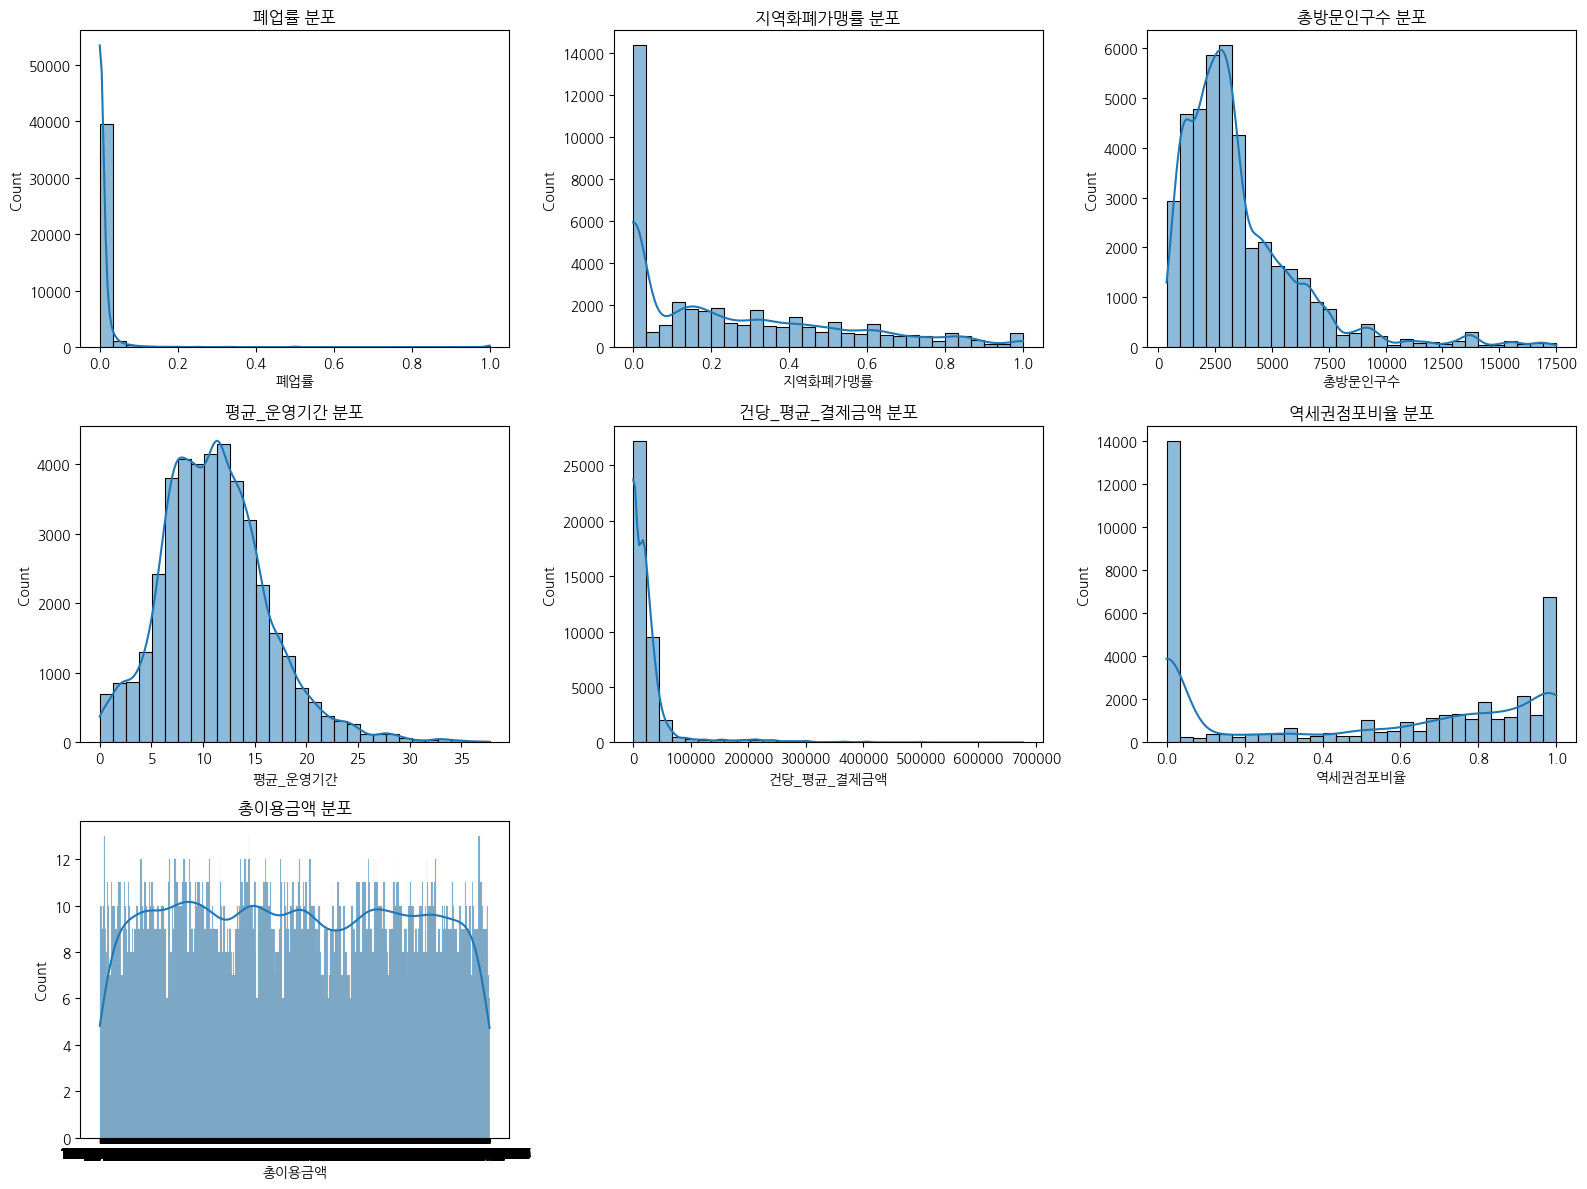

In [0]:
# 시각화 대상 변수 (로그 변환, 스케일링 전)
raw_features = [
    "폐업률",
    "지역화폐가맹률",
    "총방문인구수",
    "평균_운영기간",
    "건당_평균_결제금액",
    "역세권점포비율",
    "총이용금액"
]

# 분포 확인
plt.figure(figsize=(16, 12))
for i, col in enumerate(raw_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"{col} 분포")
plt.tight_layout()
plt.show()


### 결측치 확인  

In [0]:
features = [
    '폐업률',
    '지역화폐가맹률',
    '총방문인구수',
    '평균_운영기간',
    '건당_평균_결제금액',
    '역세권점포비율',
    '총이용금액'
]

# 쉼표 제거 + 문자열을 숫자형으로 변환
df["총이용금액"] = df["총이용금액"].astype(str).str.replace(",", "").astype(float)

# 혹시 다른 컬럼들도 문제가 있을 수 있으니 일괄 변환
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 각 피처별 결측치 수 확인
print("결측치 수:")
print(df[features].isnull().sum())

# 분포 확인
print(df[features].describe())

결측치 수:
폐업률           0
지역화폐가맹률       0
총방문인구수        0
평균_운영기간       0
건당_평균_결제금액    0
역세권점포비율       0
총이용금액         0
dtype: int64
                폐업률       지역화폐가맹률  ...       역세권점포비율         총이용금액
count  41406.000000  41406.000000  ...  41406.000000  4.140600e+04
mean       0.011312      0.256891  ...      0.487681  3.032241e+08
std        0.071790      0.274037  ...      0.407963  5.682118e+08
min        0.000000      0.000000  ...      0.000000  1.971888e+06
25%        0.000000      0.000000  ...      0.000000  7.791898e+07
50%        0.000000      0.170000  ...      0.580000  1.525111e+08
75%        0.000000      0.430000  ...      0.890000  3.167071e+08
max        1.000000      1.000000  ...      1.000000  7.016671e+09

[8 rows x 7 columns]


### 로그변환 및 스케일링  

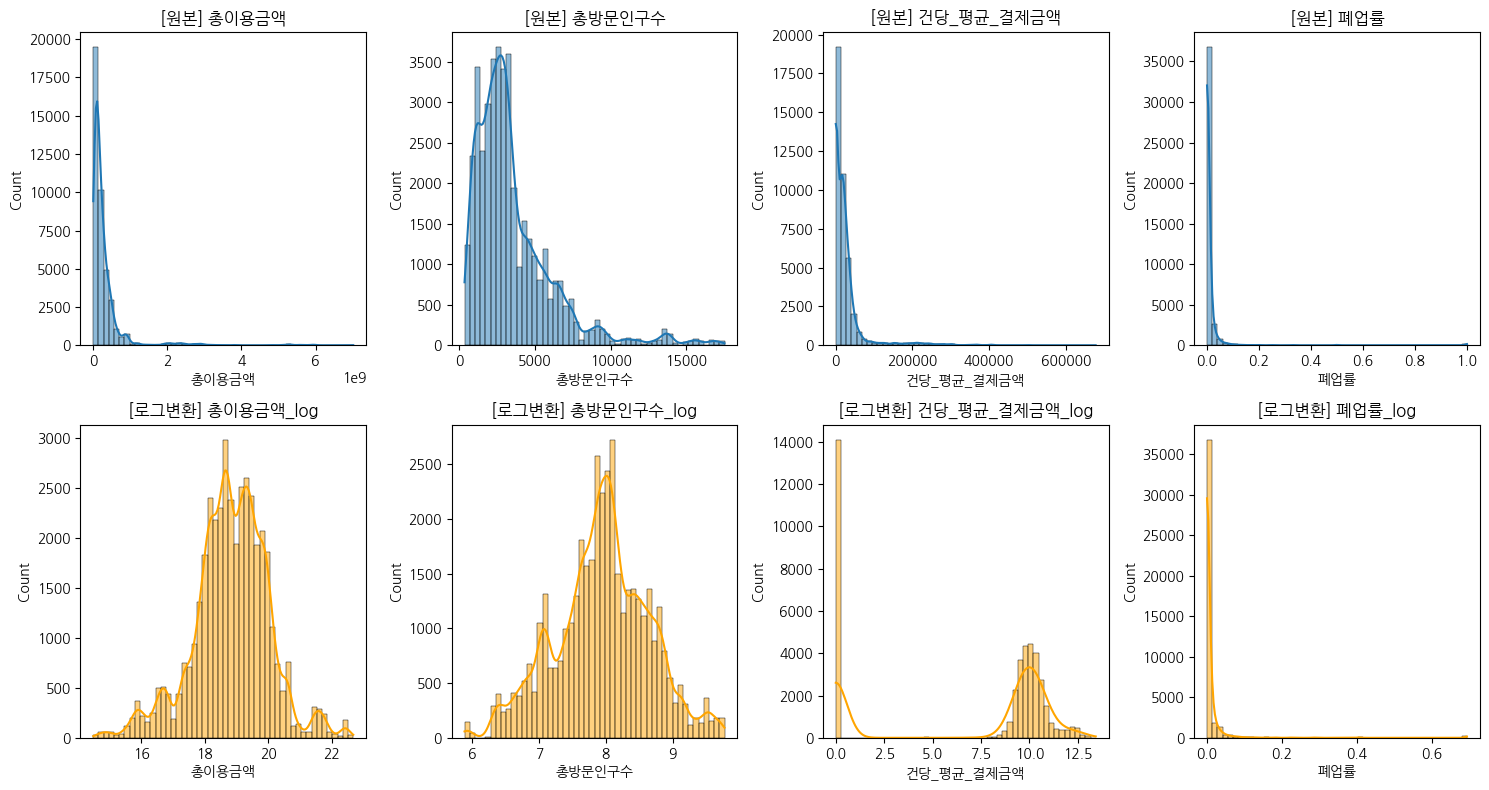

In [0]:
# 로그 변환 후보 컬럼 
log_cols = ["총이용금액", "총방문인구수", "건당_평균_결제금액", "폐업률"]

plt.figure(figsize=(15, 8))

for i, col in enumerate(log_cols):
    plt.subplot(2, 4, i + 1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"[원본] {col}")

    plt.subplot(2, 4, i + 5)
    sns.histplot(np.log1p(pd.to_numeric(df[col], errors='coerce')), bins=50, kde=True, color="orange")
    plt.title(f"[로그변환] {col}_log")

plt.tight_layout()
plt.show()


- 건당_평균_결제금액에서 0이 많은 것은 비가맹이어서 지역화폐거래 없음 처리한 부분  
- 폐업률은 0~1 사이, 대부분 0.1 이하이고 로그변환해도 차이가 없어서 그냥 두기로 결정  

### 로그변환+정규화 적용  

In [0]:
from sklearn.preprocessing import StandardScaler

# 로그 변환
df["총이용금액_log"] = np.log1p(df["총이용금액"])
df["총방문인구수_log"] = np.log1p(df["총방문인구수"])
df["건당_평균_결제금액_log"] = np.log1p(df["건당_평균_결제금액"])

# 최종 피처 리스트
features = [
    "폐업률",
    "지역화폐가맹률",
    "평균_운영기간",
    "역세권점포비율",
    "총이용금액_log",
    "총방문인구수_log",
    "건당_평균_결제금액_log"
]

# 결측치 제거 후 표준화
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 군집 수 4로 KMeans 학습
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Silhouette Score 계산
score = silhouette_score(X_scaled, labels)

print(f"군집 수 4일 때 Silhouette Score: {score:.3f}")

### 군집 수 결정  
- 엘보우 방법 (Within-cluster SSE)  

In [0]:
from sklearn.cluster import KMeans

sse = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# 시각화
plt.figure(figsize=(8, 4))
plt.plot(K_range, sse, marker='o')
plt.xlabel('군집 수 (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method (클러스터 수 vs SSE)')
plt.grid(True)
plt.show()


- k=2 → 감소량은 크지만 너무 단순함 (폐업률 높은 곳 vs 낮은 곳 식으로만 나뉠 수 있음)

- k=3~4 → 그래프 기울기 급격히 줄어듦 → 이 지점이 elbow (이후부턴 SSE 감소 폭 작음)  

### 실루엣 점수 확인 (군집 응집도 확인)  
- 개별 데이터가 할당된 군집 내 데이터와 얼마나 가깝게 군집화 되어있는지, 그리고 다른 군집에 있는 데이터와는 얼마나 멀리 분리되어 있는지를 수치로 나타냄  
- 군집이 잘 분리되었다는 것은 동일한 군집 내에서의 데이터는 서로 가깝게 위치해있으며 다른 군집과의 거리는 멀은 것  
- 값이 크다면 군집화의 성능이 좋다고 해석  

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_range = range(2, 11)
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# 시각화
plt.figure(figsize=(8, 4))
plt.plot(K_range, sil_scores, marker='o', color='tomato')
plt.title("Silhouette Score by Cluster Count")
plt.xlabel("군집 수 (k)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.show()



In [0]:
best_k = K_range[np.argmax(sil_scores)]
print(f"최적 군집 수: k = {best_k}")

최적 군집 수: k = 2


- k=2: 실루엣 스코어 가장 높음 (0.28)
- k=4: 두 번째로 높은 스코어 (0.251) / 군집 품질과 해석 가능성 균형  
- k=6 이상: 실루엣 스코어가 낮고 변화폭도 작음  

#### 군집 갯수: k=4
 -> Elbow Method 기준 SSE 감소폭이 급격히 완화되는 범위에 들어오고 
Silhouette Score 기준 두 번째로 높은 점수를 기록  

### 클러스터링  

In [0]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clustered = df.loc[X.index].copy()
df_clustered["cluster"] = cluster_labels

### 군집별 특성 확인 

In [0]:
cluster_summary2 = df_clustered.groupby('cluster')[features].mean().round(3)
cluster_summary2

,폐업률,지역화폐가맹률,평균_운영기간,역세권점포비율,총이용금액_log,총방문인구수_log,건당_평균_결제금액_log
cluster,,,,,,,
0,0.008,0.372,11.003,0.602,19.473,8.334,10.177
1,0.006,0.382,14.762,0.311,17.636,7.223,9.168
2,0.003,0.000,8.808,0.484,18.914,7.986,0.008
3,0.873,0.014,1.633,0.052,18.792,7.928,0.501


### 군집별 개수 확인  

In [0]:
print(df_clustered["cluster"].value_counts().sort_index())

0    17742
1    10548
2    12871
3      245
Name: cluster, dtype: int64


### 테이블 저장  

In [0]:
# 공통 컬럼
common_cols = [
    "cluster", "기준연월", "시군구", "행정동", "대분류명", "전체점포수", 
    "폐업률", "생존률", "지역화폐가맹률", "역세권점포비율", "평균_운영기간", 
    "월별_총거래건수", "월별_총거래금액", "건당_평균_결제금액", 
    "총방문인구수", "총주거인구수", 
] 

with_demo_cols = common_cols + [
    "남성비율_방문", "여성비율_방문", "남성비율_주거", "여성비율_주거",
    "20대미만_비율", "20대_비율", "30대_비율", "40대_비율", 
    "50대_비율", "60대_비율", "70대이상_비율",
    "새벽_소비비율", "아침_소비비율", "낮_소비비율", "저녁_소비비율", "밤_소비비율"
]

without_demo_cols = common_cols 

df_spark_all = spark.createDataFrame(df_clustered[with_demo_cols])
df_spark_simple = spark.createDataFrame(df_clustered[without_demo_cols])

In [0]:
# 정렬 후 저장 
df_spark_all = df_spark_all.orderBy("cluster", "기준연월", "시군구", "행정동", "대분류명")
df_spark_simple = df_spark_simple.orderBy("cluster", "기준연월", "시군구", "행정동", "대분류명") 

# 인구·성별·시간대 비율 포함 테이블 
df_spark_all.write.format("delta").mode("overwrite").saveAsTable(
    "gold.busan.cluster_k4_all"
)

# 최소 컬럼 버전
df_spark_simple.write.format("delta").mode("overwrite").saveAsTable(
    "gold.busan.cluster_k4"
)